Iter: 0. fit_change: 5.7564e-02. Relative error: 9.4244e-01
Iter: 1. fit_change: 1.9633e-01. Relative error: 7.4611e-01
Iter: 2. fit_change: 2.2398e-01. Relative error: 5.2213e-01
Iter: 3. fit_change: 1.2836e-01. Relative error: 3.9377e-01
Iter: 4. fit_change: 7.0155e-02. Relative error: 3.2361e-01
Iter: 5. fit_change: 5.5595e-02. Relative error: 2.6802e-01
Iter: 6. fit_change: 3.8035e-02. Relative error: 2.2998e-01
Iter: 7. fit_change: 4.4196e-02. Relative error: 1.8578e-01
Iter: 8. fit_change: 2.8880e-02. Relative error: 1.5690e-01
Iter: 9. fit_change: 2.5590e-03. Relative error: 1.5435e-01
Iter: 10. fit_change: 1.7779e-02. Relative error: 1.3657e-01
Iter: 11. fit_change: 3.1408e-02. Relative error: 1.0516e-01
Iter: 12. fit_change: 1.8833e-02. Relative error: 8.6325e-02
Iter: 13. fit_change: 8.0217e-03. Relative error: 7.8303e-02
Iter: 14. fit_change: 7.0014e-05. Relative error: 7.8233e-02
Iter: 15. fit_change: 1.0519e-07. Relative error: 7.8233e-02
Iter: 16. fit_change: 3.8935e-10. 

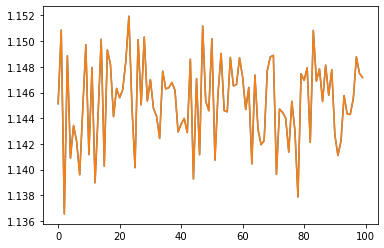

In [135]:
import numpy as np
#def f(X, noise=noise):
#    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)
import matplotlib.pyplot as plt
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Code/')
from cpd import *
MYSEED = 40
np.random.seed(MYSEED)
total_budget = 50 # Maximum number of iterations
tol = 0#1e-4#1e-32 # Tolerance in tensor decomposition

if True:
    sz = [200, 200, 200] # Size of tensor
    N = len(sz) # Number of modes
    R = 130 # Rank
    noise = 1e-1#0.#1e-24 # Amount of noise to add to generated tensor
    # # Sketch size for sampled CP decomposition
    factors_true = [randn(size=(sz[k], R)) for k in range(N)]
    X = factors_to_tensor(factors_true) + noise*randn(size=sz)
    #Tunable parameters
    #sketch_size: 3
    #sketch_switch: 3-1 = 2 
    # Generate random factor matrices and compute corresponding tensor plus noise
else:
    factors_true = [randn(size=(sz[k], R)) for k in range(N)]
    #X = factors_to_tensor(factors_true) + noise*randn(size=sz)
    outputs_true = np.load("../220415/generated_data/generate_tile_plot_seed_1.npy")

    output_true_pre = [np.transpose(outputs_true[0, :, :, s]) for s in [0,1,2] ]
    sz = [s.shape[0] for s in output_true_pre ]

    X = factors_to_tensor(output_true_pre) + noise*randn(size=sz)
    R = output_true_pre[0].shape[1]

# Factorize using deterministic method and create corresponding tensor
factors = cpd(X, R, tol=tol, maxiters=total_budget)
Y = factors_to_tensor(factors)
rel_er = norm(X-Y)/norm(X)
print('Exact CPD, rel_err',rel_er)
factors_sampled, out_sampled, timing_sampled = cpd_sampled(X, R, tol=tol, maxiters=100, sketch_size=4*R, seed=42, output_stats=True, timeit=1)
print('Sampled CPD, rel_err',out_sampled)
plt.plot(np.array(out_sampled).squeeze())
plt.plot(np.array(out_sampled).squeeze())

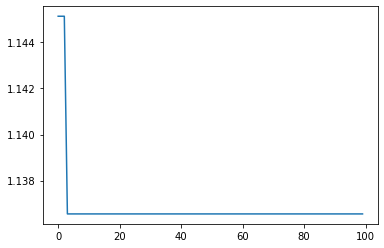

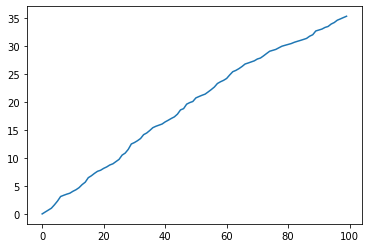

In [136]:
#Take the best-so-far error to make sure that the error sequence is monotonic decreasing
def bestError(out_seq):
    res = []
    for i in range(len(out_seq)):
        if i == 0: 
            res.append(out_seq[0])
            continue
        res.append(np.amin(out_seq[0:i]))
    return res

import matplotlib.pyplot as plt
plt.figure()
plt.plot( range(len(out_sampled)),bestError(out_sampled) )
def intervalToAccumulated(timingRecord):
    accumulatedTimingRecord = []
    for i in range(len(timingRecord)):
        accumulatedTimingRecord.append(sum(timingRecord[0:i]))
    return accumulatedTimingRecord
    #print(len(timingRecord),len(accumulatedTimingRecord))
plt.figure()
plt.plot( range(len(out_sampled)),intervalToAccumulated(timing_sampled))

In [137]:
import gpflow
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-3)
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
def bounded_parameter(low, high, default):
    """Make lengthscale tfp Parameter with optimization bounds."""
    #affine = tfb.AffineScalar(shift=tf.cast(low, tf.float64),
    #                          scale=tf.cast(high-low, tf.float64))
    affine_scale = tfb.Scale(scale=tf.cast(high-low, tf.float64))
    affine_shift = tfb.Shift(shift=tf.cast(low, tf.float64))
    sigmoid = tfb.Sigmoid()
    logistic = tfb.Chain([affine_shift, affine_scale, sigmoid])
    parameter = gpflow.Parameter(default, transform=logistic, dtype=tf.float64)
    return parameter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, RBF
#from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
#X_sample = X_init
#Y_sample = Y_init

# Update Gaussian process with existing samples
#gpr.fit(X_sample, Y_sample)

In [138]:
#Step 1: Start from a randomly chosen small sketch rate, say 10, fix this sketch rate and run a few steps,
iter_size_history = [3]*17
sketch_size_history = [R,2*R,3*R,4*R,5*R,6*R,7*R,8*R,9*R,10*R]
#assert len(iter_size_history)==len(sketch_size_history)
factors_history = [None]
sketch_pointer = 0
total_iter = 0
#For plots
bestErrorRecord = []
sketchRateRecord = []
timingRecord = []
continue_counter = 0
#total_budget = 50
VERBOSE = False
#This is a sketch size decomposition, the sum(sketch_size_history) would be the maximal 
while total_iter<total_budget:
    sketch_size = sketch_size_history[sketch_pointer]
    current_factor = factors_history[sketch_pointer]
    iter_size = 3 +int(sketch_size/500)#Basic iteration size
    #iter_size = iter_size_history[sketch_pointer]
    #Perhaps work with Osman for better error handling:
    try:#Should we really change the random seed?
        print('Now we use cpd_sampled with maxiters=',iter_size+continue_counter)
        factors_rand, out_rand, timing_rand = cpd_sampled(X, R, tol=tol, maxiters=iter_size+continue_counter, seed=MYSEED+1,\
                                                 sketch_size=sketch_size, output_stats=True, factors=current_factor, timeit=True, verbose = VERBOSE)
    except:
        print('tolerance reached error')
        break
    factors_history.append(factors_rand)
    print('factors_history length=',len(factors_history))
    print('best error so far:',bestErrorRecord)
#Step 2: Run a few using regular GP-EI, and then maintain a relative error model as above. And the relative error model would get more accurate. 
# Currently, there is no EI since the sketch_size is the only parameter to be tuned. Therefore, we are using the existing step-size to model the performance of CPD relative error.
    # Gaussian process with Matérn kernel as surrogate model
    # Fit a Gaussian process with existing samples
    #X_sample = np.array(range(iter_size+continue_counter))
    X_sample = np.array(range(len(out_rand)))
    X_sample = X_sample.astype(np.float64).reshape(-1,1)
    Y_sample = bestError(out_rand) + np.random.normal(size=(1,len(out_rand) ))*1e-10
    Y_sample = (np.array(Y_sample).astype(np.float64)).reshape(-1,1)
    try:
        assert Y_sample.shape[0]==X_sample.shape[0]
        #print(X_sample,Y_sample)
    except:
        print('unequal error, X_sample.shape=',X_sample.shape)
        print('unequal error, Y_sample.shape=',Y_sample.shape)
        break
    for j in range(len(timing_rand)):
        timingRecord.append(timing_rand[j])
        bestErrorRecord.append(bestError(out_rand)[j])
        sketchRateRecord.append(sketch_size)
        if VERBOSE: print('>>>>>>',len(bestErrorRecord),len(sketchRateRecord))
    #
    if False:
        m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
        gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

        gpr.fit(X_sample, Y_sample)

        rel_error_gp = gpr.predict(np.array(range(total_budget)).reshape(-1,1))
    else:
        X_dim = 1
        kernel = gpflow.kernels.Matern32(active_dims=range(X_dim),lengthscales=[1.]*X_dim) #+ gpflow.kernels.White()
        # frequentist fit
        global_noise_variance_lower = 1e-5
        global_noise_variance_upper = 1e-3
        global_noise_variance_init = 0.5*(global_noise_variance_lower+global_noise_variance_upper)

        model = gpflow.models.GPR(data=(X_sample, Y_sample),\
                        kernel=kernel,\
                        mean_function=None,\
                        #mean_function=mean_function,\
                        noise_variance=global_noise_variance_init)
        # We optimize this using Scipy
        model.likelihood.variance = bounded_parameter(global_noise_variance_lower, global_noise_variance_upper, global_noise_variance_init)
        if VERBOSE: gpflow.utilities.print_summary(model)

        opt = gpflow.optimizers.Scipy()
        n_maxiter = 1000
        option_opt = dict(disp=False, maxiter=n_maxiter,seed=MYSEED)
        try:
            opt_logs = opt.minimize(model.training_loss, model.trainable_variables, method='L-BFGS-B', options=option_opt)
            # Print output: optimization monitoring, estimated kernel hyperparameters, coregionalization matrix
            if VERBOSE:  print(opt_logs)
            if VERBOSE:  gpflow.utilities.print_summary(model)
            likelihood = model.log_marginal_likelihood()
            if VERBOSE:  tf.print(f"Optimizer: L-BFGS-B loglik_marg: {likelihood: .04f}")      
            gp_mean, gp_cov = model.predict_f(np.array(range(total_budget)).astype(float).reshape(-1,1),full_cov=False)

            rel_error_gp = gp_mean.numpy()#.reshape(1,-1)
            rel_error_gp_cov = gp_cov.numpy()
            IMPROVEMENT_GP = True
    
        except:
            rel_error_gp = np.array(range(total_budget)).astype(float).reshape(-1,1)*0.
            #Non-invertible covariance matrix in GP, caused by no-improvement.
            IMPROVEMENT_GP = False

    rel_error_gp_grad = np.gradient(np.array(rel_error_gp).squeeze())
    if VERBOSE: 
        plt.scatter(np.array(range(iter_size+continue_counter)).reshape(-1,1),np.array(out_rand).reshape(-1,1),label='relative error(raw)',color='blue' )
        plt.scatter(np.array(range(iter_size+continue_counter)).reshape(-1,1),np.array(bestError(out_rand)).reshape(-1,1),label='relative error(best)',color='red' )
        plt.plot(np.array(range(total_budget)).reshape(-1,1),rel_error_gp.reshape(-1,1),label='GP sketch rate='+str(sketch_size),color='red')
        plt.plot(rel_error_gp_grad,label='GP slope',color='green')
        plt.legend()
        plt.show()
#Step 3: If the relative error model says there is not much improvement ahead, we switch to another (larger) sketch rate, using a steplength, say +10.
#(Once the model is deemed to be accurate enough, the trade-off would be goodness of fit and the number of samples before switch) This step is tentative, need to discuss with Osman/Jim/Sherry/Yang
    #Find the first index where the gradient of the GP prediction falls below.
    grad_threshold = 0.01
    seq_threshold = np.argwhere( np.abs(rel_error_gp_grad[(iter_size+continue_counter):-1])> grad_threshold ) 
    if len(seq_threshold)>0:
        iter_goal = max(seq_threshold)[0]
    else:
        iter_goal = 0
    if VERBOSE: print(seq_threshold,iter_goal)
    #This expression above is the last iteration count where the norm of gradient (or simpler, the absolute value of gradient) is at least as large as grad_threshold (so that we can deem enough improvement until this step)
    if iter_size+continue_counter < iter_goal and IMPROVEMENT_GP:
        factors_history.pop()
        for j in range(len(timing_rand)):
            #itm = timing_rand[j]
            timingRecord.pop()#append(itm)
            bestErrorRecord.pop()#.append(out_rand[j])
            sketchRateRecord.pop()#.append(sketch_size)
        print('Yes> It is worth doing a few more steps at sketch rate=',sketch_size,'until ',iter_goal,' total iteration at this rate. continue_counter=',continue_counter)
        continue_counter = continue_counter + 1
    else:
        total_iter = total_iter + (iter_size + continue_counter)
        if sketch_pointer<len(sketch_size_history)-1:
            sketch_pointer = sketch_pointer + 1
            continue_counter = 0
        else:
            print('No usable sketch_rate any more from the list.')
            #break
            #use the rest budget at highest sketch_rate
            continue_counter = total_budget - total_iter - iter_size
        
        print('No> It is not worth doing any more steps, next sketch rate=',sketch_size_history[sketch_pointer])
#Step 4: Repeat steps 2 and 3 until we are running out of sampling budget (or to look at the plateau of previous GP process before switching, so that we could get an accurate solution as fast as possible). 
# What is an appropriate termination step? The following is a simple termination step. 
    print('Total steps so far:',total_iter)
    if total_iter>total_budget: break

Now we use cpd_sampled with maxiters= 3
factors_history length= 2
best error so far: []


/home/hrluo/anaconda3/lib/python3.8/site-packages/gpflow/optimizers/scipy.py:90: OptimizeWarning: Unknown solver options: seed
  return scipy.optimize.minimize(


Yes> It is worth doing a few more steps at sketch rate= 130 until  13  total iteration at this rate. continue_counter= 0
Total steps so far: 0
Now we use cpd_sampled with maxiters= 4
factors_history length= 2
best error so far: []
Yes> It is worth doing a few more steps at sketch rate= 130 until  12  total iteration at this rate. continue_counter= 1
Total steps so far: 0
Now we use cpd_sampled with maxiters= 5
factors_history length= 2
best error so far: []
Yes> It is worth doing a few more steps at sketch rate= 130 until  12  total iteration at this rate. continue_counter= 2
Total steps so far: 0
Now we use cpd_sampled with maxiters= 6
factors_history length= 2
best error so far: []
Yes> It is worth doing a few more steps at sketch rate= 130 until  9  total iteration at this rate. continue_counter= 3
Total steps so far: 0
Now we use cpd_sampled with maxiters= 7
factors_history length= 2
best error so far: []
Yes> It is worth doing a few more steps at sketch rate= 130 until  12  total 

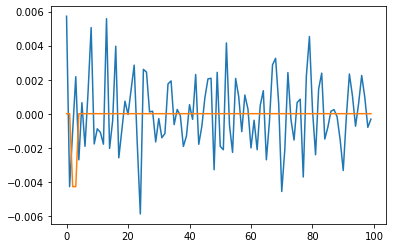

In [139]:
plt.plot(np.gradient(np.array(out_sampled).squeeze()))
plt.plot(np.gradient(np.array(bestError(out_sampled)).squeeze()))


Text(0, 0.5, 'Relative error')

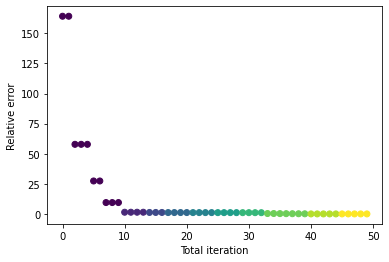

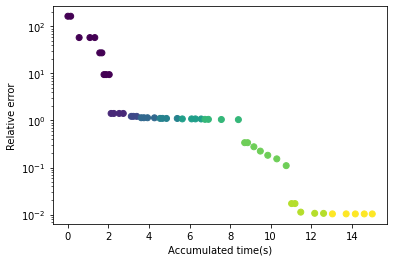

In [140]:
#for i in np.unique(sketchRateRecord):
#    print(i)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(range(len(bestErrorRecord)),bestErrorRecord,c=sketchRateRecord)
plt.xlabel('Total iteration')
plt.ylabel('Relative error')

plt.figure()
plt.scatter(intervalToAccumulated(timingRecord)[0:len(bestErrorRecord)],bestErrorRecord,c=sketchRateRecord)
plt.yscale('log')
plt.xlabel('Accumulated time(s)')
plt.ylabel('Relative error')



In [141]:
np.asarray(sketchRateRecord)[np.where(np.asarray(bestErrorRecord) >0.8)]

array([130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 260, 260, 260,
       260, 390, 390, 390, 520, 520, 520, 520, 650, 650, 650, 650, 780,
       780, 780, 780, 910, 910, 910, 910])

In [142]:
plotData_out_sampled = []
plotData_timing_sampled = []
plotData_out_acc = []
plotData_timing_acc =[]
print(MYSEED)
for sketch_size_fixed in sketch_size_history:
    print('sketch_size_fixed=',sketch_size_fixed)
    factors_sampled, out_sampled, timing_sampled = cpd_sampled(X, R, tol=tol, maxiters=total_budget, sketch_size=sketch_size_fixed, seed=MYSEED+1, output_stats=True, timeit=True, verbose=False)
    #factors_sampled, out_sampled, timing_sampled = cpd_sampled(X, R, tol=tol, maxiters=total_budget, sketch_size=sketch_size_fixed, seed=43, output_stats=True, timeit=True)
    plotData_out_sampled.append(out_sampled)
    plotData_timing_sampled.append(timing_sampled)
    plotData_out_acc.append(bestError(out_sampled))
    plotData_timing_acc.append(intervalToAccumulated(timing_sampled))
    

40
sketch_size_fixed= 130
sketch_size_fixed= 260
sketch_size_fixed= 390
sketch_size_fixed= 520
sketch_size_fixed= 650
sketch_size_fixed= 780
sketch_size_fixed= 910
sketch_size_fixed= 1040
sketch_size_fixed= 1170
sketch_size_fixed= 1300


In [143]:
#print(sketch_size_fixed,tol)
#cpd_sampled(X, R, tol=tol, maxiters=50, sketch_size=100, seed=MYSEED, output_stats=True, timeit=True, verbose=True)
#plt.scatter( range(50),plotData_timing_acc[-1])

In [144]:
#print('>>>>>>',len(bestErrorRecord),len(sketchRateRecord))
import json
with open('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_plotData_out_sampled.json', "w") as fp:
    json.dump(plotData_out_sampled, fp)
with open('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_plotData_timing_sampled.json', "w") as fp:
    json.dump(plotData_timing_sampled, fp)
with open('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_plotData_out_acc.json', "w") as fp:
    json.dump(plotData_out_acc, fp)
with open('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_plotData_timing_acc.json', "w") as fp:
    json.dump(plotData_timing_acc, fp)
np.savetxt('Adapt_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_bestError.csv',np.asarray(bestErrorRecord).squeeze())
np.savetxt('Adapt_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_bestTime.csv',np.asarray(intervalToAccumulated(timingRecord)).squeeze())
np.savetxt('Adapt_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_sketchRateRecord.csv',np.asarray(sketchRateRecord).squeeze())

/tmp/ipykernel_708345/4128825932.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0.,2.)


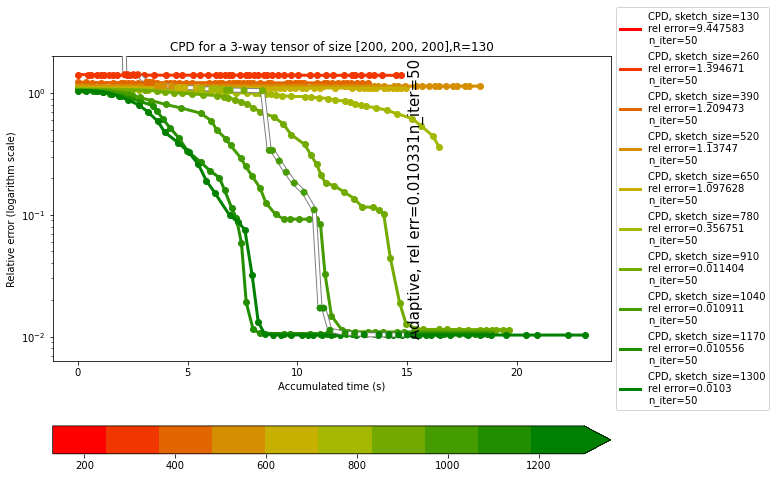

In [145]:
#Let's do an envelop fitting using GP. It seems that the medium sketch rate behaves the best in terms of relative error?
X_total_sample = np.array( range(len(bestErrorRecord)) ).reshape(-1,1)
Y_total_sample = np.array( bestErrorRecord ).reshape(-1,1)
m52 = RBF()
gpr = GaussianProcessRegressor(kernel=m52, alpha=0.1**2)

mycmap = plt.get_cmap('jet', len(sketch_size_history))

gpr.fit(X_total_sample, Y_total_sample)
plt.figure(figsize=(10,8))
import matplotlib
from colour import Color
red = Color("red")
mycmap = list(red.range_to(Color("green"),10))
mymatplotcmap = matplotlib.colors.ListedColormap([s.hex_l for s in mycmap])

#plt.plot( gpr.predict(np.array(range(50)).reshape(-1,1)),label='GP envelope' )
counter = 0
for sketch_size_fixed in sketch_size_history:
    #print('sketch_size_fixed=',sketch_size_fixed)
    used_iter = len(plotData_out_acc[counter])
    plt.plot( plotData_timing_acc[counter],plotData_out_acc[counter], label= 'CPD, sketch_size='+str(sketch_size_fixed)+'\nrel error='+str(np.round(plotData_out_acc[counter][-1],6))+'\nn_iter='+str(used_iter),color=mycmap[counter].hex_l,linewidth=3 )
    plt.scatter( plotData_timing_acc[counter],plotData_out_acc[counter], color=mycmap[counter].hex_l)
    #plt.plot( plotData_timing_acc[counter],plotData_out_sampled[counter], label= 'CPD, sketch_size='+str(sketch_size_fixed)+'\nrel error='+str(np.round(plotData_out_acc[counter][-1],6))+'\nn_iter='+str(used_iter),color=mycmap[counter].hex_l,linewidth=3 )
    #plt.scatter( plotData_timing_acc[counter],plotData_out_sampled[counter], color=mycmap[counter].hex_l)
    #plt.text(x=intervalToAccumulated(timing_sampled)[-1]+0.06*counter, y=bestError(out_sampled)[-1], s='sketch_size:'+str(sketch_size_fixed)+'\nrel err:'+str(np.round(bestError(out_sampled)[-1],6)),rotation=90, size=10)
    counter = counter + 1

plt.plot(intervalToAccumulated(timingRecord),bestErrorRecord,color='gray',linewidth=5,zorder=99)
plt.plot(intervalToAccumulated(timingRecord),bestErrorRecord,color='white',linewidth=3,zorder=99)
plt.scatter(intervalToAccumulated(timingRecord),bestErrorRecord,c=sketchRateRecord,cmap=mymatplotcmap,zorder=99)
used_iter = len(bestErrorRecord)
plt.text(x=intervalToAccumulated(timingRecord)[-1], y=bestErrorRecord[-1], s='Adaptive, rel err='+str(np.round(bestErrorRecord[-1],6))+'n_iter='+str(used_iter),rotation=90, size=15)
plt.colorbar(extend="max",location="bottom",fraction=0.15)

plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.,2.)
#plt.xlabel('Total iteration')
plt.xlabel('Accumulated time (s)')
plt.ylabel('Relative error (logarithm scale)')
plt.title('CPD for a 3-way tensor of size '+str(sz)+',R='+str(R))
plt.savefig('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'.png', dpi=600,bbox_inches = "tight")

In [146]:
def first_passage(time_seq_acc,error_seq_acc,threshold,return_time=True,cutoff=np.inf):#If false, return first passage index
    if return_time:
        whereseq = np.where(np.asarray(error_seq_acc)<threshold)
        if len(whereseq[0])>0:
            return time_seq_acc[whereseq[0][0]]
        else:
            return cutoff
    else:
        whereseq = np.where(np.asarray(error_seq_acc)<threshold)
        if len(whereseq[0])>0:
            return whereseq[0][0]
        else:
            return cutoff

sketch_size= 130
sketch_size= 260
sketch_size= 390
sketch_size= 520
sketch_size= 650
sketch_size= 780
sketch_size= 910
sketch_size= 1040
sketch_size= 1170
sketch_size= 1300


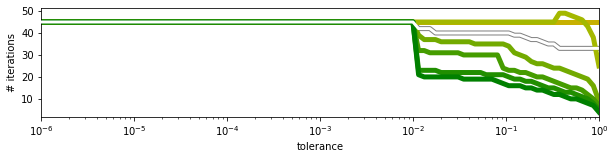

In [147]:
threshold_seq = 10**(-1.*np.linspace(0,6,100))
plt.figure(figsize=(10,2))
thres_time_seq = []
MAXTIME = 45
for thres in threshold_seq:
    thres_time = first_passage(intervalToAccumulated(timingRecord),bestErrorRecord,thres,False,MAXTIME)  
    #plt.vlines(x=thres, ymin=0, ymax=thres_time,linewidth=50)
    thres_time_seq.append(thres_time)
plt.plot(threshold_seq, thres_time_seq, linewidth=5,color='gray')
plt.plot(threshold_seq, thres_time_seq, linewidth=3,color='white',zorder=99,label='Adaptive')
counter = 0
for sketch_size_fixed in sketch_size_history:
    print('sketch_size=',sketch_size_history[counter])
    thres_counter = 0
    thres_time_seq = []
    for thres in threshold_seq:
        thres_time =  first_passage(plotData_timing_acc[counter],plotData_out_acc[counter],thres,False,MAXTIME)  
        #plt.vlines(x=thres, ymin=0, ymax=thres_time+(counter*(threshold_seq[thres_counter + 1]-thres)/len(threshold_seq)),linewidth=50,color=mycmap[counter].hex_l)
        thres_counter = thres_counter + 1
        thres_time_seq.append(thres_time)
    plt.plot(threshold_seq, thres_time_seq,linewidth=5,color=mycmap[counter].hex_l,label= 'CPD, sketch_size='+str(sketch_size_fixed))
    counter = counter + 1
    #print('sketch_size_fixed=',sketch_size_fixed)
    #factors_sampled, out_sampled, timing_sampled = cpd_sampled(X, R, tol=tol, maxiters=50, sketch_size=sketch_size_fixed, seed=sketch_size_fixed, output_stats=True, timeit=True, verbose=False)
    #plt.plot( plotData_timing_acc[counter],plotData_out_acc[counter], label= 'CPD, sketch_size='+str(sketch_size_fixed)+'\nrel error='+str(np.round(plotData_out_acc[counter][-1],6)),color=mycmap[counter].hex_l,linewidth=3 )
    #plt.scatter( plotData_timing_acc[counter],plotData_out_acc[counter], color=mycmap[counter].hex_l)
    #plt.text(x=intervalToAccumulated(timing_sampled)[-1]+0.06*counter, y=bestError(out_sampled)[-1], s='sketch_size:'+str(sketch_size_fixed)+'\nrel err:'+str(np.round(bestError(out_sampled)[-1],6)),rotation=90, size=10)
    #counter = counter + 1
plt.xlim(min(threshold_seq),1)
plt.xscale('log')
plt.xlabel('tolerance')
plt.ylabel('# iterations')
#plt.legend()
plt.savefig('CPD_'+str(MYSEED)+'_'+str(sz)+'_R_'+str(R)+'_'+str(tol)+'_'+str(total_budget)+'_ITER.png', dpi=600,bbox_inches = "tight")